In [1]:
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from antlia import lidar
from antlia import plot_braking as braking

%matplotlib inline
DEFAULT_FIGSIZE = (12, 8)

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [3]:
import IPython.display

def animate_braking(rid, tid, xlim, ylim, speedup=1, **kwargs):
    record = records[rid]
    trial = record.trial[tid]
    
    m, _, _, _ = braking.get_metrics(trial.data)
    
    t0 = m['braking starttime']
    t1 = m['braking endtime']

    frames = record.lidar.frame(lambda t: (t >= t0 - 1) & (t < t1 + 1))
        
    c = sns.color_palette('Paired', 10)[1::2]
    colors = [c[2]
              if (t > t0) and (t < t1) else c[1]
              for t in frames.time]
    
    return frames.animate(xlim, ylim, speedup, colors, **kwargs)

def display_animation(animation):
    plt.close(animation._fig)
    IPython.display.display(IPython.display.HTML(ani.to_html5_video()))
    
    
for rid, tid in [[0, 6]]:
#for rid, tid in itertools.product(range(3, 4), range(1)):
    record = records[rid]
    trial = record.trial[tid]
    
    ani = animate_braking(rid, tid,
                          xlim=(0, 50),
                          ylim=(0, 2),
                          speedup=0.5,
                          plot_kwargs={'marker': 'o'})
    ani._fig.get_axes()[0].set_title('rider {} trial {:02d}'.format(rid, tid))
    display_animation(ani)

rider 0, trial 2
average rider x: 42.97164073139187
trial dtc: 6.448359268608128


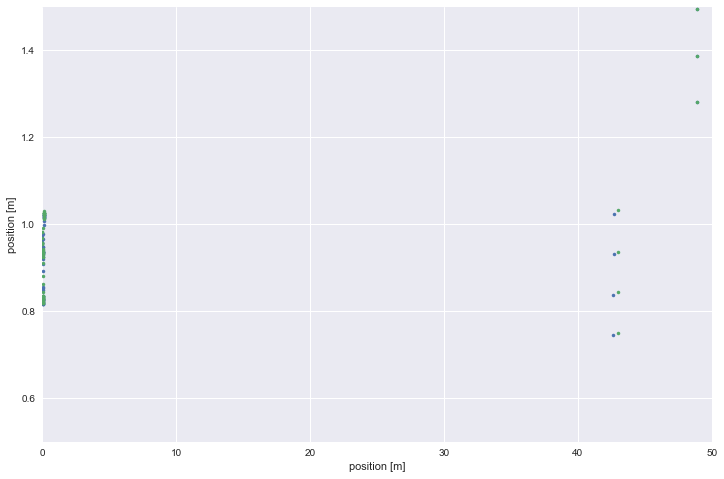

In [4]:
plt.close('all')
for rid, tid in [[0, 2]]:
    record = records[rid]
    trial = record.trial[tid]
    try:
        m, _, _, _ = braking.get_metrics(trial.data)
    except TypeError:
        continue
    print('rider {}, trial {}'.format(rid, tid))
    
    # TODO: interpolate between frames
    # TODO: account for bicycle length? need to go from pedal to front wheel
    index1 = record.lidar.frame_index(m['braking starttime'][0])
    
    xlim = (0, 50)
    ylim = (0.5, 1.5)
    fig, ax = plt.subplots()
        
    x, y = record.lidar[index1 - 1].cartesian(xlim=xlim, ylim=ylim)
    ax.plot(x.compressed(), y.compressed(), linestyle=' ', marker='.')
    x, y = record.lidar[index1].cartesian(xlim=xlim, ylim=ylim)
    ax.plot(x.compressed(), y.compressed(), linestyle=' ', marker='.')
        
    ax.set_xlabel('position [m]')
    ax.set_ylabel('position [m]')
    ax.set_xlim((0, 50))
    ax.set_ylim(ylim)
    
    rider_x = x[np.where((x > 10) & (x < 48))] 
    print('average rider x: {}'.format(rider_x.mean()))
    
    # _rough estimate_ from crank to front wheel center.
    # TODO: measure value instead of just estimating
    # TODO: need to include wheel and account for height of lidar
    forward_length = 0.580
    dtc = 50 - rider_x.mean() - forward_length
    print('trial dtc: {}'.format(dtc))
plt.show()

In [5]:
def calculate_dtc(rid, tid):
    record = records[rid]
    trial = record.trial[tid]
    m, _, _, _ = braking.get_metrics(trial.data)
        
    index = record.lidar.frame_index(m['braking starttime'][0])
    index = [-1 + index, index]
    
    xlim = (0, 50)
    ylim = (0.5, 1.5)
        
    dtc = []
    for i in index:
        x, _ = record.lidar[[i]].cartesian(xlim=xlim, ylim=ylim)
        x = x.compressed()
        rider_x = x[np.where((x > 10) & (x < 48))]
        
        # _rough estimate_ from crank to front wheel center.
        # TODO: measure value instead of just estimating
        # TODO: need to include wheel and account for height of lidar
        # TODO: stabilization between frames
        forward_length = 0.580
        
        dtc.append(50 - rider_x.mean() - forward_length)
    
    t = record.lidar[np.array(index)].time.flatten()
    return np.interp(m['braking starttime'], t, dtc)[0], m

calculate_dtc(0, 2)

(6.5168800888999838,
 array([ (-1.72348435,  715.84898323, -0.74410543,   2.76832297e-44,  0.0994677,  6.07819461,  1.952244,  8.70374047,  411.786928,  413.739172, 55, [2212, 2456], 0, 0, 0)], 
       dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]))

In [6]:
import pandas as pd

def get_dataframe(records):
    """Define function to get metrics for lidar data.
    """
    metrics = []
    dtc = []
    for rid, tid in itertools.product(range(4), range(15)):
        try:
            x, m = calculate_dtc(rid, tid)
        except TypeError:
            print('skipping {}, {}'.format(rid, tid))
            continue
        
        dtc.append(x)
        
        m['rider id'] = rid
        m['trial id'] = tid
        metrics.append(m)
        
    metrics = np.concatenate(metrics)
    # exclude non-scalar fields
    names = [dtype[0]
             for dtype in metrics.dtype.fields.items()
             if dtype[1][0].shape == ()]
    
    df = pd.DataFrame(metrics[names])
    df['distance-to-collision'] = dtc
    
    f = lambda row: row['distance-to-collision']/row['starting velocity']
    df['time-to-collision'] = df.apply(f, axis=1)
    return df
 
df = get_dataframe(records)
# DTC/TTC calculations will be 'nan' if not detected by lidar
# lidar only has a guaranteed detection range of 30 m
df

skipping 0, 0
skipping 0, 1


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: Mean of empty slice.
/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,linregress stderr,trial id,braking distance,linregress intercept,braking starttime,linregress slope,lockup ranges,braking duration,braking endtime,starting velocity,linregress r-value,rider id,window size,linregress p-value,distance-to-collision,time-to-collision
0,0.099468,2,8.703740,715.848983,411.786928,-1.723484,0,1.952244,413.739172,6.078195,-0.744105,0,55,2.768323e-44,6.516880,1.072174
1,0.514137,3,2.140694,691.587816,493.557209,-1.393157,0,0.600076,494.157285,3.937731,-0.302307,0,55,8.387193e-03,NaN,NaN
2,0.118824,4,6.070381,773.491082,571.154965,-1.345448,0,1.512189,572.667154,4.857473,-0.637766,0,55,5.695965e-23,8.103559,1.668266
3,0.213894,5,5.122003,1630.390552,677.698360,-2.397210,0,1.160147,678.858507,5.533575,-0.683830,0,55,2.569676e-21,5.757083,1.040391
4,0.130077,6,4.557585,710.990535,766.029467,-0.922756,0,1.288163,767.317630,4.031114,-0.490318,0,55,4.054087e-11,NaN,NaN
5,0.199042,7,4.753165,1504.730026,846.439577,-1.771827,0,1.216154,847.655731,4.699092,-0.587936,0,55,1.672730e-15,5.985708,1.273801
6,0.119038,8,7.729463,1618.459859,910.143588,-1.771589,0,1.696212,911.839800,5.855901,-0.716459,0,55,1.107465e-34,8.540690,1.458476
7,0.432361,9,2.901759,1798.833210,1020.986526,-1.757588,0,0.792097,1021.778623,4.146971,-0.381527,0,55,9.763750e-05,5.185877,1.250522
8,0.272392,10,5.537081,1821.773991,1090.427257,-1.665790,0,1.296161,1091.723418,4.927042,-0.435266,0,55,7.108176e-09,6.203900,1.259153
9,0.131949,11,9.849418,1766.450561,1152.203024,-1.527542,0,2.024254,1154.227278,6.070815,-0.589990,0,55,4.058286e-25,7.786642,1.282635


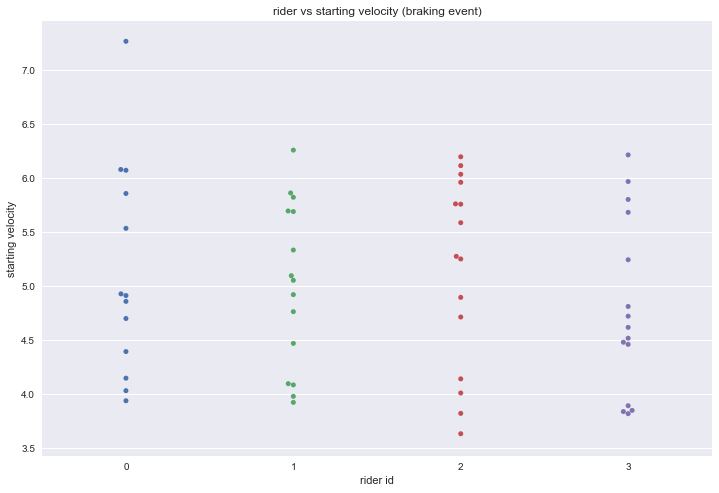

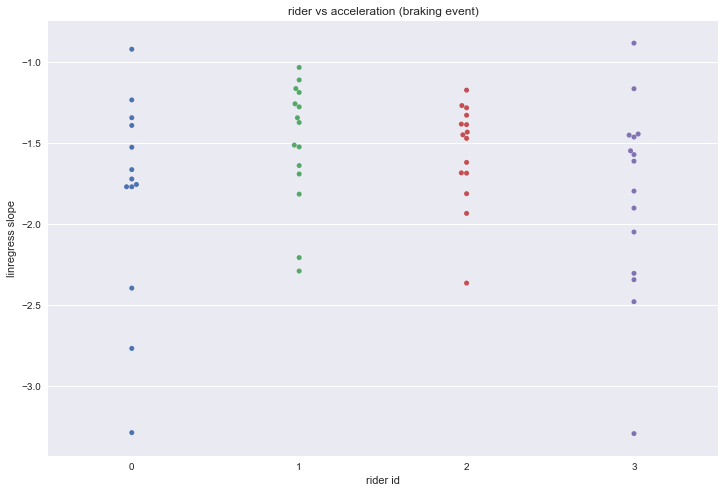

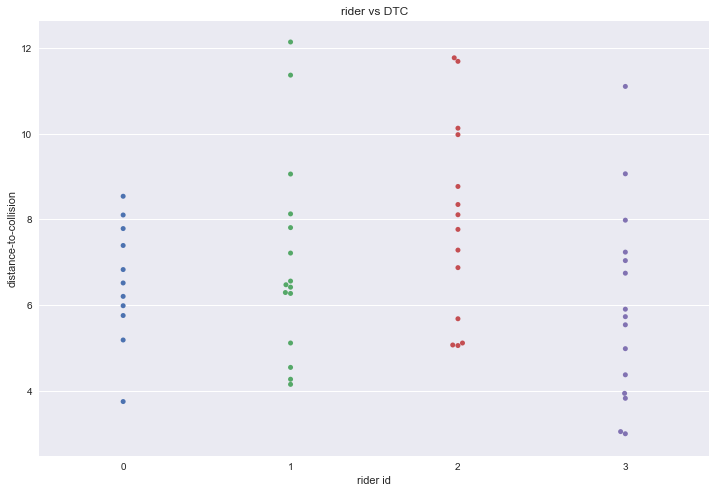

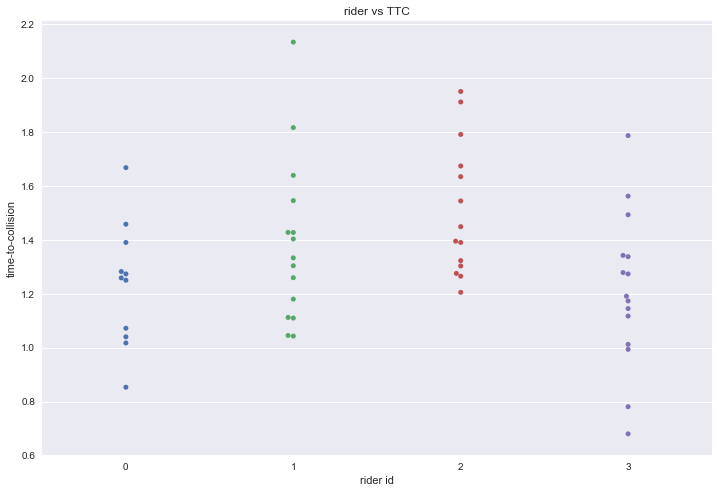

In [7]:
plt.close('all')
fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='starting velocity', data=df, ax=ax)
ax.set_title('rider vs starting velocity (braking event)')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='linregress slope', data=df, ax=ax)
ax.set_title('rider vs acceleration (braking event)')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='distance-to-collision', data=df, ax=ax)
ax.set_title('rider vs DTC')

fig, ax = plt.subplots()
sns.swarmplot(x='rider id', y='time-to-collision', data=df, ax=ax)
ax.set_title('rider vs TTC')
plt.show()

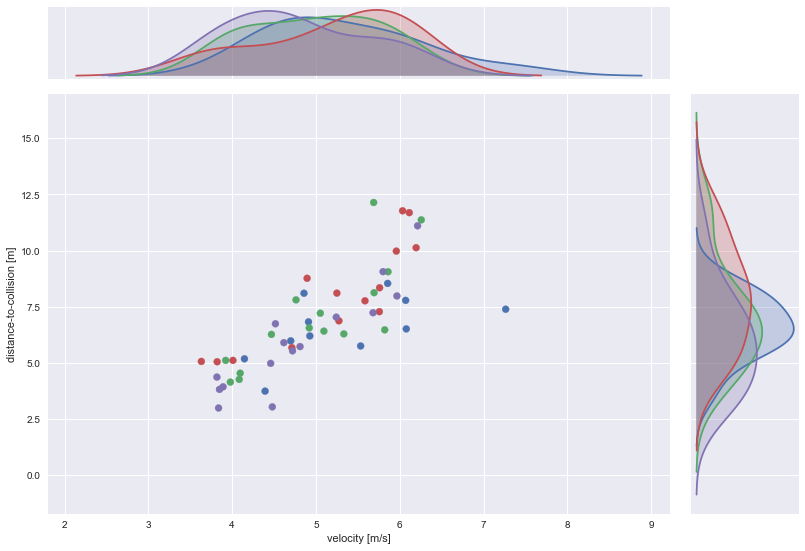

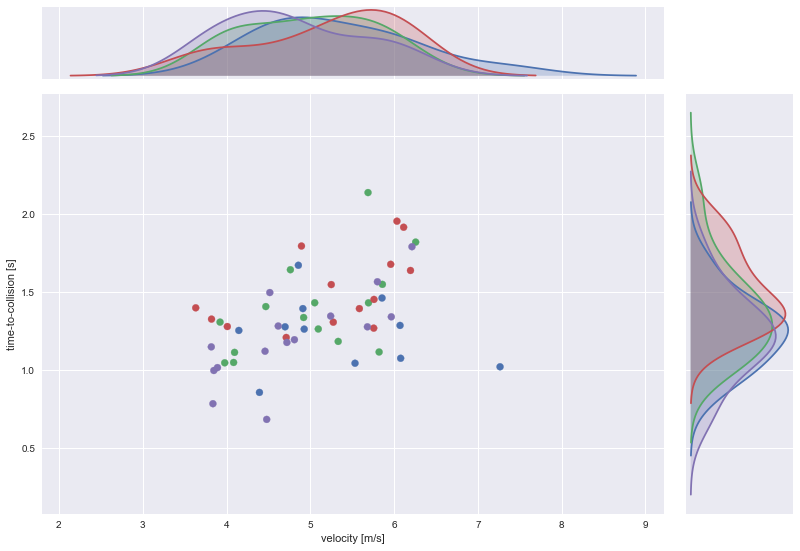

In [8]:
from antlia.plotdf import plotjoint

colors = sns.color_palette()

plt.close('all')
g = plotjoint('starting velocity', 'distance-to-collision',
              df[np.isfinite(df['time-to-collision'])],
              ('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'distance-to-collision [m]')

g = plotjoint('starting velocity', 'time-to-collision',
              df[np.isfinite(df['time-to-collision'])],
              ('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'time-to-collision [s]')
plt.show()